# Navigation

---

In this notebook, we will train an agent to navigate and collect bananas in a large, square world. We will use the Unity ML-Agents environment. This is the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Necessary Packages
For this project, we need the following packages.


In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent
from unityagents import UnityEnvironment

### 2. Examine the state and action spaces
Now, let's examine the state and action spaces. First, let's start the unity environment

In [2]:
env = UnityEnvironment(file_name=r"Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train the Agent with DQN

The function below called `dqn` trains a DQN agent from scratch. First, the environment is started and the default brain was set as shown above. Then the agent is initialized. The agent has many hyperparameters (buffer_size, batch_size, gamma, etc); for the time being we use their default values, see the `Agent` class. In the `__init__` method of `Agent`, the deep Q networks are initalized. Currently we are using an MLP with two hidden layers each having 64 nodes. `ReLU` is used as the activation function in both hidden layers. To change the network design, see the `QNetwork` class in `model.py`.

We set the number of episodes as 1000. However, if we observe an average score of +13.5 over 100 consecutive episodes, we stop the training and save the model to `model.pth`.

In [9]:
def dqn(n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #env = UnityEnvironment(file_name=r"Banana_Windows_x86_64\Banana.exe")

    # get the default brain
    #brain_name = env.brain_names[0]
    #brain = env.brains[brain_name]
    
    # Initialize the agent. 
    agent = Agent(state_size=37, action_size=4, seed=0)

    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_averages = []
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]  # get the current state
        score = 0
        while True:
            action = agent.act(state, eps).astype(np.int32)
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward  # update the score
            state = next_state  # roll over the state to next time step
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        moving_averages.append(np.mean(scores_window))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.1:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
            break
    env.close()
    return scores, moving_averages

Let's train the agent, and get the score per episode, and average score over the past 100 episodes.

In [10]:
scores, moving_averages = dqn()

Episode 100	Average Score: 1.17
Episode 200	Average Score: 3.75
Episode 300	Average Score: 7.74
Episode 400	Average Score: 11.61
Episode 449	Average Score: 13.18
Environment solved in 449 episodes!	Average Score: 13.18


Let's plot the score per episode and the average score over the past 100 episodes

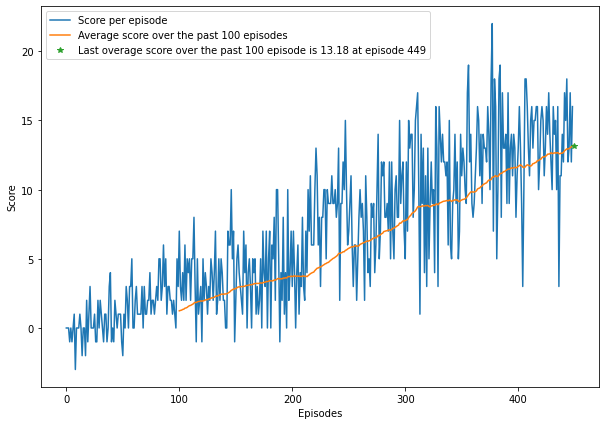

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(len(scores)), scores, label='Score per episode')
ax.plot(np.arange(100, len(scores)), moving_averages[100:], label='Average score over the past 100 episodes')
ax.plot(len(scores), moving_averages[-1], '*', label=f'Last overage score over the past 100 episode is {moving_averages[-1]} at episode {len(scores)}')
ax.set_xlabel('Episodes')
ax.set_ylabel('Score')
ax.legend()